In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u 
from astropy.table import Table
from gammapy.irf import EffectiveAreaTable2D, EnergyDispersion2D

In [2]:
filename = '1dc/caldb/data/cta/1dc/bcf/North_z20_50h/irf_file.fits'
aeff = EffectiveAreaTable2D.read(filename)
edisp = EnergyDispersion2D.read(filename,hdu='ENERGY DISPERSION')

In [3]:
print(edisp)
print(edisp.data.axes[0].nodes.value[260])

EnergyDispersion2D
NDDataArray summary info
e_true         : size =   500, min =  0.005 TeV, max = 495.450 TeV
migra          : size =   300, min =  0.005, max =  2.995
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size = 900000, min =  0.000, max = 16039.922

2.01837


/Users/terrier/Code/anaconda2/lib/python2.7/site-packages/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/Users/terrier/Code/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:1154: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/Users/terrier/Code/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


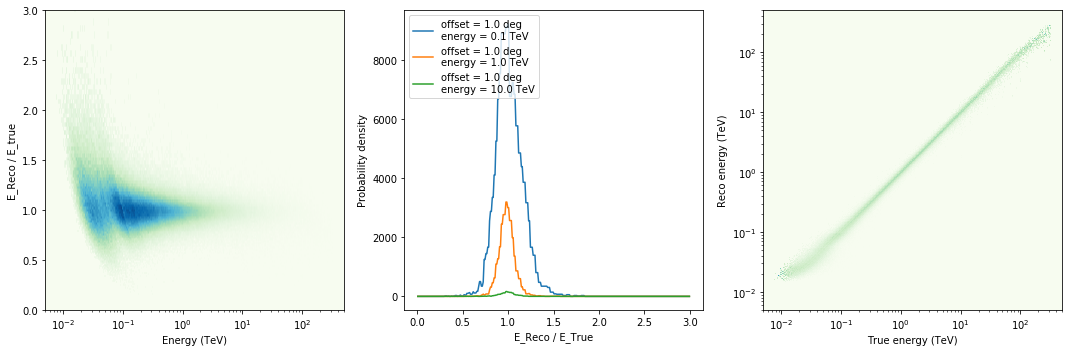

In [4]:
edisp.peek()

Look at effect of extrapolation towards 0. We look at bin number 260 in e_true, i.e. 2 TeV.

Negative values appear in the distribution of migration

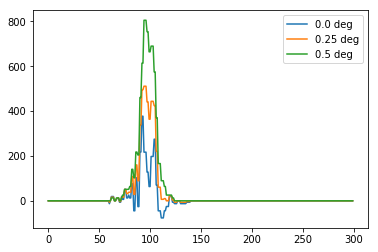

In [5]:
for offset in (0.0*u.deg, 0.25*u.deg, 0.5*u.deg):
    val = edisp.data.evaluate(offset = offset,
                              e_true=edisp.data.axes[0].nodes.value[260]*u.TeV)
    plt.plot(val,label=str(offset))
    
plt.legend()

Now look at extracted 1D edisp (rmf)

In [6]:
rmfOK = edisp.to_energy_dispersion(offset=0.5*u.deg)
rmfbad = edisp.to_energy_dispersion(offset=0.0*u.deg)



At 0.5° it is OK

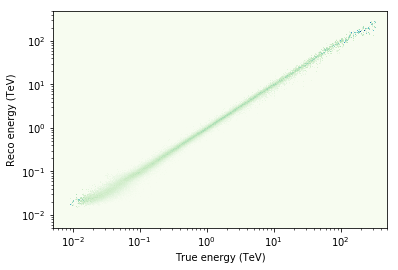

In [7]:
rmfOK.plot_matrix()

At 0° this looks bad.

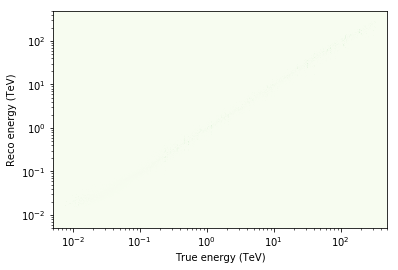

In [8]:
rmfbad.plot_matrix()

Let's look at 'predicted' number of counts.

They can get negative in the extrapolated case.

The easiest workaround is to force offset extraction at 0.5° in case it is lower.

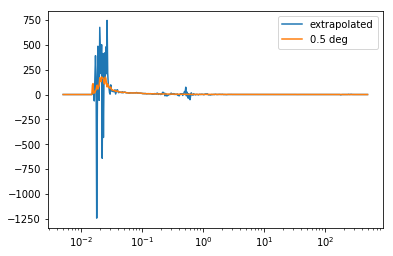

In [9]:
model = rmfbad.e_true.log_center()**-1
plt.semilogx(rmfbad.e_reco.log_center(),rmfbad.apply(model),label='extrapolated')
plt.semilogx(rmfbad.e_reco.log_center(),rmfOK.apply(model),label='0.5 deg')
plt.legend()



## Proposed patch to remove negative predicted counts

Simply suppress negative values produced by EnergyDispersion2D.get_response

In [10]:
from gammapy.utils.energy import EnergyBounds, Energy
def get_response(self, offset, e_true, e_reco=None, migra_step=5e-3):
        """Detector response R(Delta E_reco, E_true)

        Probability to reconstruct a given true energy in a given reconstructed
        energy band. In each reco bin, you integrate with a riemann sum over
        the default migra bin of your analysis.

        Parameters
        ----------
        e_true : `~gammapy.utils.energy.Energy`
            True energy
        e_reco : `~gammapy.utils.energy.EnergyBounds`, None
            Reconstructed energy axis
        offset : `~astropy.coordinates.Angle`
            Offset
        migra_step : float
            Integration step in migration

        Returns
        -------
        rv : `~numpy.ndarray`
            Redistribution vector
        """
        e_true = Energy(e_true)

        # Default: e_reco nodes = migra nodes * e_true nodes
        if e_reco is None:
            e_reco = EnergyBounds.from_lower_and_upper_bounds(
                self.migra.lo * e_true, self.migra.hi * e_true)
            migra = self.migra.nodes
        # Translate given e_reco binning to migra at bin center
        else:
            e_reco = EnergyBounds(e_reco)
            center = e_reco.log_centers
            migra = center / e_true

        # migration value of e_reco bounds
        migra_e_reco = e_reco / e_true

        # Define a vector of migration with mig_step step
        mrec_min = self.migra.lo[0]
        mrec_max = self.migra.hi[-1]
        mig_array = np.arange(mrec_min, mrec_max, migra_step)

        # Compute energy dispersion probability dP/dm for each element of migration array
        vals = self.data.evaluate(offset=offset, e_true=e_true, migra=mig_array)

        # Remove negative values likely caused by extrapolation if IRF is not defined properly
        vals[np.where(vals<0.)] = 0.0
        
        # Compute normalized cumulative sum to prepare integration
        tmp = np.nan_to_num(np.cumsum(vals) / np.sum(vals))

        # Determine positions (bin indices) of e_reco bounds in migration array
        pos_mig = np.digitize(migra_e_reco, mig_array) - 1
        # We ensure that no negative values are found
        pos_mig = np.maximum(pos_mig, 0)

        # We compute the difference between 2 successive bounds in e_reco
        # to get integral over reco energy bin
        integral = np.diff(tmp[pos_mig])

        return integral
    
EnergyDispersion2D.get_response = get_response    


In [11]:
rmfOK = edisp.to_energy_dispersion(offset=0.5*u.deg)
rmfbad = edisp.to_energy_dispersion(offset=0.0*u.deg)



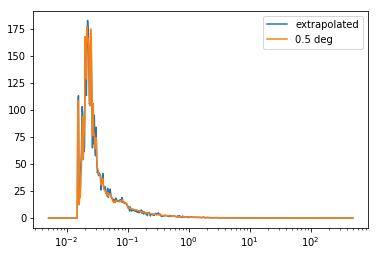

In [12]:
model = rmfbad.e_true.log_center()**-1
plt.semilogx(rmfbad.e_reco.log_center(),rmfbad.apply(model),label='extrapolated')
plt.semilogx(rmfbad.e_reco.log_center(),rmfOK.apply(model),label='0.5 deg')
plt.legend()

